# Induction heating verification

Verification of Elmer simulations for induction heating.

Theory according to S. Lupi: Fundamentals of Electroheat, Chapter 6. Springer, 2017.

Simulations with Elmer v9.0, pyelmer v0.3.2 and Gmsh 4.8.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Sketch
From Lupi2017 p.358:

![Sketch](geometry.png)

## Assumptions
- Infinite axial length
- Displacement currents neglected
- Sinusoidal waves
- Axisymmetric

## Notation
The notation is according to Lupi2017:
- $\dot{H}$ - time dependant value / amplitude and
- $H$ - rms-value

is used for all electromagnetic variables. Under the assumption of sinusoidal waves $H=\frac{\dot{H}}{\sqrt{2}}$ applies.

## Cz-Growth parameters
The parameters of the induction heating verification case shall be similar to the experiment.

Geometry parameters:
\begin{align}
    r_e &= 0.06~\mathrm{m}\\
    l_{coil} &= 0.042 \mathrm{m}\\
    N_{coil} &= 3
\end{align}

Electromagnetic parameters:
\begin{align}
    \dot{I} &= 100~\mathrm{A}\\
    f &= 13.5 \cdot 10^3~\mathrm{Hz}\\
    \omega &= 2 \pi f \approx 84800~\frac{1}{\mathrm{s}}\\
    \sigma &= 5.88\cdot 10^4~\frac{\mathrm{S}}{\mathrm{m}}\\
    \rho &= \frac{1}{\sigma}\\
\end{align}

Resulting induction heating parameters:
\begin{align}
    \delta &= \sqrt{\frac{2\rho}{\omega \mu_0}} \approx 0.018~\mathrm{m}\\
    m &= \frac{\sqrt{2}r_e}{\delta} \approx 4.72\\
    \dot{H}_e &= \frac{N_{coil} \dot{I}}{l_{coil}} \approx 7143~\frac{\mathrm{A}}{\mathrm{m}}
\end{align}

In [2]:
r_e = 0.06
l = 0.042
N = 3
I = 100
omega = 84800
sigma = 5.88e4
rho = 1/sigma
H = N*I/l
delta = (2 * rho / (omega * 4e-7 * np.pi))**0.5
print("delta =", delta)
m = 2**0.5 * r_e / delta
print('m =', m)

delta = 0.017865841496117037
m = 4.7494440024461


## Distribution of Joule heat

Current density (Lupi2017 p.361 eqn 6.9) 
\begin{align}
    \dot{J} = \sqrt{-j}\cdot \dot{H}_e \cdot \frac{\sqrt{2}}{\delta}\cdot\frac{J_1(\sqrt{-j}\cdot m \xi)}{J_0(\sqrt{-j}\cdot m)}
\end{align}
with $J_0$ and $J_1$ Bessel functions of zero and first order, respectively. An alternative formulation of this equation in Davies1990 p.96 is equal (compared Davies1990 p.96 eqn 9.10 to Lupi2017 p.362 eqn 6.9a). The resulting joule heat distribution is then given by
\begin{align}
    w &= \rho J^2 = \rho \frac{\dot{J}^2}{2}
\end{align}

In [3]:
def J(xi, H, delta, m):
    J = (-1j)**0.5 * H * 2**0.5 / delta * jv(1, (-1j)**0.5 * m * xi) / jv(0, (-1j)**0.5 * m)
    return J

## Total induced power
At the outer surface of the cylinder ($\xi=1$) applies (Lupi2017 p.362 eqn 6.11):
\begin{align}
    \dot{J}_e =  \sqrt{-j}\cdot \dot{H}_e \cdot \frac{\sqrt{2}}{\delta}\cdot \frac{J_1(\sqrt{-j}\cdot m)}{J_0(\sqrt{-j}\cdot m)} = -\dot{H}_e\frac{m}{r_e} (P + j\cdot Q)
\end{align}

The coefficients P and Q are given by (Lupi2017 p.362 eqn 6.12):
\begin{align}
    P + j\cdot Q = - \sqrt{-j}\cdot \frac{J_1(\sqrt{-j}\cdot m)}{J_0(\sqrt{-j}\cdot m)}
\end{align}

In [4]:
from scipy.special import jv

P_jQ = -np.sqrt(-1j) * jv(1, np.sqrt(-1j) * m) / jv(0, np.sqrt(-1j) * m)
P = np.real(P_jQ)
Q = np.imag(P_jQ)
print('P = ', P)

P =  0.5992592690772168


The induced power computed from Poynting vector is given by (Lupi2017 p. 367 eqn 6.17):
\begin{align}
    P_w &= H_e^2 \frac{\rho}{\delta} \sqrt{2} P 2\pi r_e l
    = \frac{\dot{H}_e^2}{2} \frac{\rho}{\delta} \sqrt{2} P 2\pi r_e l
\end{align}

In [5]:
P_w = H**2 / 2 * rho / delta * 2**0.5 * P * 2 * np.pi * r_e * l
print('P_w =', P_w, 'W')

P_w = 325.85418077478806 W


## Elmer Simulation
### Parameters
For to fulfill the assumption of an infinite domain, the inner section (of length $l$) of a long coil ($l_{tot} >> 2r_i$) is analyzed. This is controlled by the parameter
\begin{align}
    n_l = \frac{l_{tot}}{l}
\end{align}

In [6]:
n_l = 20
l_tot = n_l * l
print('l_tot =', l_tot, 'm')

l_tot = 0.8400000000000001 m


For the coil (modeled by a rectangle) the following values are set:
\begin{align}
    N_{coil} &= 1\\
    I &= \frac{\dot{H}_e l_{tot}}{N_{coil}}\\
    r_i &= {0.04}~\mathrm{m}\\
    d &= {0.01}~\mathrm{m}
\end{align}

In [7]:
N = 1
r_i = 0.07
d = 0.01

I = H * l_tot / N
print('I =', I, 'A')

I = 6000.0 A


### Geometry modeling
Geometry and mesh generation using Gmsh, using the refinement factor $\alpha_{mesh}$.

In [8]:
from induction_heating import geometry

alpha_mesh = 1.5
ph_cylinder, ph_cylinder_ends, ph_coil, ph_air, ph_cylinder_surf, ph_outside_surfs = geometry(l, n_l, r_e, r_i, d, alpha_mesh=alpha_mesh, with_cylinder=True)

Overview of the mesh:

![mesh](mesh.png)

Zoom at the cylinder in the center of the coil:

![mesh-zoom](mesh-zoom.png)

### Solvers
Use solver *MagnetoDynamics2DHarmonic* and *MagnetoDynamicsCalcFields* or *StatMagSolver* to evaluate electromagnetics. These solvers are active in the whole domain.

The solver *HeatSolver* is only active in the cylinder in the middle of the coil, where the induction heating is to be analyzed.

### Boundary conditions
**Electromagnetics:** A potential of zero is prescibed at the outer surfaces.

**Thermodynamics:** At the top and bottom boundaries (inner cylinder to top and bottom one), no boundary conditions is prescribed, which means that a natural boundary condition with zero heat flux applies. At the outer surface of the cylinder a fixed temperature of 20°C is set.

### Evaluation
The heat flux over this boundary, which is in the steady state equal to the induced heat, is analyzed by summing up the *boundary loads* using the *SaveScalars* solver. The value is written to *scalars.dat*. The value needs to be multiplied by $2\pi$ to get the total power in Watt.

In [9]:
from induction_heating import sif
from pyelmer import execute

sif(ph_cylinder, ph_cylinder_ends, ph_coil, ph_air, ph_cylinder_surf, ph_outside_surfs, omega, I, rho, d, l_tot, mgdyn=False, with_cylinder=True)

Wrote sif-file.


In [10]:
execute.run_elmer_grid('./simdata/', 'induction_verification.msh2')
execute.run_elmer_solver('./simdata/')

## Evaluation of joule heat
Manual extraction using ParaView, PlotOverLine (center of cylinder) -> Save Data (as csv). The ParaView state file used to extract the data shown here is stored under simdata/extract-data.psvm

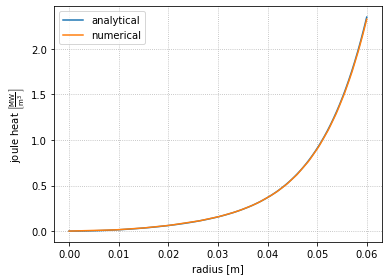

In [11]:
# analytical
xi = np.linspace(0, 1, 100)
J_xi = J(xi, H, delta, m)
w = rho * np.abs(J_xi)**2 / 2
# numerical
df = pd.read_csv('./simdata/line-data.csv')

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
ax.grid(linestyle=":")
line, = ax.plot(xi * r_e, w/1e6)
line.set_label('analytical')
line, = ax.plot(df['Points:0'], df['joule heating']/1e6)
line.set_label('numerical')
ax.legend()
ax.set_xlabel('radius [m]')
ax.set_ylabel('joule heat $\\left[\\frac{\\mathrm{MW}}{\mathrm{m}^3}\\right]$')
fig.tight_layout()
fig.savefig("verification_joule-heat.png")
plt.show()

## Evaluation of total induced power
Read induced power computed by Elmer and compare it to analytical computed value.

In [12]:
with open('./simdata/scalars.dat') as f:
    data = f.readlines()
last_iteration = data[-1]
P_w_elmer = -1*float(last_iteration.split('   ')[0]) * 2*np.pi

print('Analytical: \tP_w =', P_w, 'W')
print('Elmer: \t\tP_w =', P_w_elmer, 'W')

dev = (P_w_elmer - P_w) / P_w
print('')
print('Deviation:\t', dev * 100, '%')

Analytical: 	P_w = 325.85418077478806 W
Elmer: 		P_w = 323.7300617881577 W

Deviation:	 -0.6518618179394939 %
